# Photometry with Photutils

Photutils is an affiliated package of Astropy to provide tools for detecting and performing photometry of astronomical sources.

It contains tools for:

* **Background Estimation (photutils.background)**
* **Source Detection (photutils.detection)**
* Grouping Algorithms
* **Aperture Photometry (photutils.aperture)**
* PSF Photometry (photutils.psf)
* PSF Matching (photutils.psf.matching)
* Image Segmentation (photutils.segmentation)
* Centroids (photutils.centroids)
* Morphological Properties (photutils.morphology)
* Geometry Functions (photutils.geometry)
* Datasets (photutils.datasets)
* Utility Functions (photutils.utils)

In [1]:
import warnings
import os.path
from glob import glob

from astropy import wcs

# FITS files are rather old and do not conform to FITS standard
warnings.filterwarnings("ignore", category=wcs.FITSFixedWarning)

%run plotfits.ipynb # Load plotting function

## Astrometry

Images of M67 have no astrometric calibration in header and, therefore, pixel positions cannot be directly transformed to sky coordinates. The usual way to calibrate a science images is by using [Astrometry.net](http://astrometry.net/) [(Lang et al., 2010)](https://ui.adsabs.harvard.edu/abs/2010AJ....139.1782L/abstract). However, the installation procedure in Windows is quite complex and requires a quite large amount of time. Therefore, the instructions to astrometrically calibrate the M67 images are shown here, but only the final producs provided in resources will be used. 

The commands to obtain the astrometric calibration of the M67 images are:

```
cd resources/red_data
solve-field bf_m67_b_1.fit --config ../resources/astrometry/astrometry.cfg
solve-field bf_m67_b_2.fit --config ../resources/astrometry/astrometry.cfg
solve-field bf_m67_b_3.fit --config ../resources/astrometry/astrometry.cfg
solve-field bf_m67_y_1.fit --config ../resources/astrometry/astrometry.cfg
solve-field bf_m67_y_2.fit --config ../resources/astrometry/astrometry.cfg
solve-field bf_m67_y_3.fit --config ../resources/astrometry/astrometry.cfg
cp *.wcs ../resources/astrometry
```

The result of this execution already provides astrometrically calibrated FITS images (named `*.new`), but in order to illustrate the use of WCS functionality, the `*.wcs` files will be used. These files contain the tranformation from pixel positions to celestial coordinates in a format called [World Coordinate System](https://docs.astropy.org/en/stable/wcs/) (WCS), a standard for FITS files. The goal is to introduce this information into the clean M67 images. 

In [2]:
for wcs_calib in glob(os.path.join('..', 'resources', 'astrometry', '*.wcs')):
    basename = os.path.basename(wcs_calib).replace('wcs', 'fit')
    clean_name = os.path.join('..','resources', 'red_data', basename)
    calibrated_name = clean_name.replace('bf_', 'bfa_')
    
    wcs_header = fits.open(wcs_calib)[0].header
    clean_image = fits.open(clean_name)
    
    clean_image[0].header.extend(wcs_header, update=True)
    clean_image.writeto(calibrated_name, overwrite=True)

plot(calibrated_name)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Once astrometric calibration is introduced in the images, some information can be retrieved:

In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

wcs_info = wcs.WCS(clean_image[0].header)
pixel_scaling = wcs.utils.proj_plane_pixel_scales(wcs_info) * u.degree
pixel_scale = np.mean(pixel_scaling).to(u.arcsec)
print('Pixel scale is:', pixel_scale)

corners = SkyCoord(wcs_info.calc_footprint(), unit=(u.degree, u.degree))
corners.to_string('hmsdms')

Pixel scale is: 0.3308071503461028 arcsec


['08h51m46.5103s +11d54m30.6233s',
 '08h50m14.1257s +11d54m48.9044s',
 '08h50m13.5605s +11d43m28.3836s',
 '08h51m46.0383s +11d43m13.1748s']

## Photometry

### Image statistics

Before performing any photometry we need to have a first guess of the image background properties of our science images of M67. Let's get the basic statistics of it. For that we will need to remove the sources using a sigma clipping routine:

In [4]:
from astropy.stats import sigma_clipped_stats, median_absolute_deviation
from astropy.io import fits
from astropy import table

rows = []
for filename in glob(os.path.join('..', 'resources', 'red_data', 'bfa_*.fit')):
    print('Reading', filename)
    extension = fits.open(filename)[0]
    values = list(sigma_clipped_stats(extension.data, sigma=3.0, maxiters=5))
    rows.append([filename] + values + [extension.data.T])

columns = ['Filename', 'Mean', 'Median', 'Deviation', 'Image']
statistics = table.Table(rows=rows, names=columns)
statistics.sort('Filename')
statistics.show_in_notebook()

Reading ../resources/red_data/bfa_m67_y_1.fit
Reading ../resources/red_data/bfa_m67_b_1.fit
Reading ../resources/red_data/bfa_m67_y_2.fit
Reading ../resources/red_data/bfa_m67_b_2.fit
Reading ../resources/red_data/bfa_m67_b_3.fit
Reading ../resources/red_data/bfa_m67_y_3.fit


idx,Filename,Mean,Median,Deviation,"Image [2048,4096]"
0,../resources/red_data/bfa_m67_b_1.fit,1.354893095341699,1.0284766416909186,7.252372356153649,5.02035623961696 .. -6.012158544496072
1,../resources/red_data/bfa_m67_b_2.fit,1.2782829187370097,1.0179031428818623,7.205967043586792,-7.530534359425439 .. -6.012158544496072
2,../resources/red_data/bfa_m67_b_3.fit,1.7650904715152704,1.9548863664831666,7.254203585455808,-12.550890599042399 .. 2.0040528481653572
3,../resources/red_data/bfa_m67_y_1.fit,2.9596026780052633,2.982758996697442,7.446737058420283,-32.91969559225166 .. -2.0399970209642047
4,../resources/red_data/bfa_m67_y_2.fit,2.4110683238701793,2.061867835629255,7.4314133315971365,-7.054220484053927 .. -9.17998659433892
5,../resources/red_data/bfa_m67_y_3.fit,2.7031735057485697,2.946897337217367,7.492249357924582,-32.91969559225166 .. -6.1199910628926135


### Object detection

To detect the sources inside a astronomical image [Photutils](https://photutils.readthedocs.io/en/stable/) provides several implementations. We will use `DAOStarFinder`:

In [5]:
from photutils import DAOStarFinder
sigma_detection = 5.0
fwhm = 1.5 * u.arcsec / pixel_scale

sources = []
for image in statistics:
    filename = image['Filename']
    std = image['Deviation']
    median = image['Median']
    daofind = DAOStarFinder(fwhm=fwhm.value, threshold=sigma_detection*std)
    photometry = daofind(image['Image'] - median)
    photometry['Filename'] = [filename] * len(photometry)
    sources.append(photometry)

catalogs = table.vstack(sources).group_by('Filename')
catalogs[:10].show_in_notebook()

idx,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,Filename
0,1,3992.110473002428,3.2188745667742262,0.41176982935242745,0.16650656377345174,0.2933704928555384,25,0.0,1189.747487683951,31.230357724434665,-3.7364423970835214,../resources/red_data/bfa_m67_b_1.fit
1,2,2695.233718002877,4.016332582540563,0.3809537948079985,0.14211677525653474,0.23433145147006412,25,0.0,193.1424787668545,4.9911335374791275,-1.7454979738611007,../resources/red_data/bfa_m67_b_1.fit
2,3,234.76982776345545,6.237169243142523,0.40817300417140306,0.14690553151949792,0.2008369134562583,25,0.0,11147.805759547426,290.1299945836169,-6.156481574753717,../resources/red_data/bfa_m67_b_1.fit
3,4,3040.6451209251877,11.232663793186774,0.40791507827633344,0.06647251636045522,0.18326919794285754,25,0.0,1579.097079950966,39.83989692944013,-4.000795515453871,../resources/red_data/bfa_m67_b_1.fit
4,5,1595.9308813344012,12.676218737958328,0.3354251691735172,0.30322743298701815,0.35849226927866645,25,0.0,297.0590123586043,7.879111505738869,-2.241193116721871,../resources/red_data/bfa_m67_b_1.fit
5,6,6.276044632978212,15.278005615658628,0.5943410230669366,-0.6009903341045414,-0.5515124342908391,25,0.0,70.7684441357749,2.825031247088944,-1.1275581395596643,../resources/red_data/bfa_m67_b_1.fit
6,7,444.4201114468266,15.350135313697539,0.4105874131994785,0.1550740345342791,0.23042806403846747,25,0.0,1029.6288138892533,26.211512968806787,-3.5462302245374335,../resources/red_data/bfa_m67_b_1.fit
7,8,937.0651596004664,20.53668847811261,0.9516137867265346,0.2855843215765107,0.723218321257578,25,0.0,287.4293664065342,7.011645661354624,-2.1145499014669893,../resources/red_data/bfa_m67_b_1.fit
8,9,2060.691422768723,25.24147441595333,0.3963360043027161,0.14227487566770874,0.21816756947962213,25,0.0,9417.307182018389,239.5840531052572,-5.948644769279898,../resources/red_data/bfa_m67_b_1.fit
9,10,2878.713262442088,34.08976456995122,0.4240428024551826,0.0544664761865616,0.3419434002100493,25,0.0,124.99051528039011,3.0383817852000847,-1.2066058596201226,../resources/red_data/bfa_m67_b_1.fit


In order to validate the result, the data of the first image can be plotted:

In [6]:
%matplotlib widget
import matplotlib.pyplot as plt

filename = catalogs.groups.keys[0][0]

plot(filename)

sources = catalogs.groups[0]
plt.scatter(sources['xcentroid'], sources['ycentroid'], alpha=0.5, color='limegreen')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Some of the objects detected are not real stars, but CCD artifacts. The best way to identify them is to evaluate their `sharpness` and `roundness`. We are going to select only the stars with `sharpness` and `roundness` around the median values:

In [7]:
valid = []
for filename, sources in zip(catalogs.groups.keys, catalogs.groups):
    sharpness = sources['sharpness']
    roundness = sources['roundness1']

    sharp_med = np.median(sharpness)
    sharp_mas = median_absolute_deviation(sharpness)
    round_med = np.median(roundness)
    round_mas = median_absolute_deviation(roundness)

    mask = (sharpness - sharp_med)**2 < 9 * sharp_mas**2 
    mask &= (roundness - round_med)**2 < 9 * round_mas**2
    mask &= sources['peak'] < 50000

    valid += list(mask)

    print(f'Found {len(sources[mask])} of {len(sources)} '
          f'valid stars in {filename[0]}')

catalogs.add_column(valid, index=1, name='valid')
    
fig = plt.figure()
plt.scatter(sharpness, roundness)
plt.scatter(sharpness[mask], roundness[mask], color='red')
plt.show(fig)

Found 314 of 491 valid stars in ../resources/red_data/bfa_m67_b_1.fit
Found 315 of 453 valid stars in ../resources/red_data/bfa_m67_b_2.fit
Found 328 of 459 valid stars in ../resources/red_data/bfa_m67_b_3.fit
Found 341 of 452 valid stars in ../resources/red_data/bfa_m67_y_1.fit
Found 324 of 444 valid stars in ../resources/red_data/bfa_m67_y_2.fit
Found 321 of 449 valid stars in ../resources/red_data/bfa_m67_y_3.fit


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

To illustrate what has been done, the first image can be plotted again:

In [8]:
plot(filename[0])

plt.scatter(sources['xcentroid'], sources['ycentroid'], alpha=0.5, color='limegreen')
plt.scatter(sources['xcentroid'][~mask], sources['ycentroid'][~mask], alpha=0.5, color='red')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

As it can be seen, stars not fulfilling the criteria are considered invalid. 

An important aspect to be addressed is that the images looks properly calibrated, but the photometry table does not contain the sky positions of the stars. To solve that `wcs` can be used:

In [14]:
origin = 0

pos = []
for filename, sources in zip(catalogs.groups.keys, catalogs.groups):
    wcs_transform = wcs.WCS(fits.open(filename[0])[0].header)
    coords = SkyCoord.from_pixel(sources['xcentroid'], sources['ycentroid'],
                                 wcs_transform, origin)

    pos += list(coords.to_string('hmsdms'))

catalogs.add_column(pos, index=2, name='Coordinates')
catalogs[:10].show_in_notebook()

idx,id,valid,Coordinates,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,Filename
0,1,True,08h51m45.4787s +11d32m25.6485s,3992.110473002428,3.2188745667742262,0.41176982935242745,0.16650656377345174,0.2933704928555384,25,0.0,1189.747487683951,31.230357724434665,-3.7364423970835214,../resources/red_data/bfa_m67_b_1.fit
1,2,True,08h51m45.8134s +11d39m37.5034s,2695.233718002877,4.016332582540563,0.3809537948079985,0.14211677525653474,0.23433145147006412,25,0.0,193.1424787668545,4.9911335374791275,-1.7454979738611007,../resources/red_data/bfa_m67_b_1.fit
2,3,True,08h51m46.3412s +11d53m12.7866s,234.76982776345545,6.237169243142523,0.40817300417140306,0.14690553151949792,0.2008369134562583,25,0.0,11147.805759547426,290.1299945836169,-6.156481574753717,../resources/red_data/bfa_m67_b_1.fit
3,4,True,08h51m45.5607s +11d37m42.6571s,3040.6451209251877,11.232663793186774,0.40791507827633344,0.06647251636045522,0.18326919794285754,25,0.0,1579.097079950966,39.83989692944013,-4.000795515453871,../resources/red_data/bfa_m67_b_1.fit
4,5,False,08h51m45.892s +11d45m42.4525s,1595.9308813344012,12.676218737958328,0.3354251691735172,0.30322743298701815,0.35849226927866645,25,0.0,297.0590123586043,7.879111505738869,-2.241193116721871,../resources/red_data/bfa_m67_b_1.fit
5,6,False,08h51m46.1862s +11d54m28.2753s,6.276044632978212,15.278005615658628,0.5943410230669366,-0.6009903341045414,-0.5515124342908391,25,0.0,70.7684441357749,2.825031247088944,-1.1275581395596643,../resources/red_data/bfa_m67_b_1.fit
6,7,True,08h51m46.0924s +11d52m03.5722s,444.4201114468266,15.350135313697539,0.4105874131994785,0.1550740345342791,0.23042806403846747,25,0.0,1029.6288138892533,26.211512968806787,-3.5462302245374335,../resources/red_data/bfa_m67_b_1.fit
7,8,False,08h51m45.8679s +11d49m20.6928s,937.0651596004664,20.53668847811261,0.9516137867265346,0.2855843215765107,0.723218321257578,25,0.0,287.4293664065342,7.011645661354624,-2.1145499014669893,../resources/red_data/bfa_m67_b_1.fit
8,9,True,08h51m45.4975s +11d43m08.3613s,2060.691422768723,25.24147441595333,0.3963360043027161,0.14227487566770874,0.21816756947962213,25,0.0,9417.307182018389,239.5840531052572,-5.948644769279898,../resources/red_data/bfa_m67_b_1.fit
9,10,True,08h51m45.0904s +11d38m36.6212s,2878.713262442088,34.08976456995122,0.4240428024551826,0.0544664761865616,0.3419434002100493,25,0.0,124.99051528039011,3.0383817852000847,-1.2066058596201226,../resources/red_data/bfa_m67_b_1.fit


## PSF Modelling

We assumed that the image had a typical value of 1.5" per pixel. But we can make a more accurate estimation by fitting the pixels to a moffat profile around a detected star.

First, let's select the source we want to use for PSF modelling. For that, we are going to select the brightest **valid** star:

In [15]:
psf_sources = catalogs[:0]
for filename, sources in zip(catalogs.groups.keys, catalogs.groups):
    sources.sort('mag')
    selected = sources[sources['valid']][0]
    psf_sources.add_row(selected)
    
psf_sources.show_in_notebook()

idx,id,valid,Coordinates,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,Filename
0,87,True,08h51m38.2834s +11d48m28.1799s,1100.5693262362788,356.88626483363316,0.39939678351289865,0.1648255684236962,0.18896198046164894,25,0.0,40234.55398932964,1007.2172044439047,-7.507807838547863,../resources/red_data/bfa_m67_b_1.fit
1,405,True,08h51m07.0583s +11d46m50.4296s,1414.3709410941906,1741.011159228569,0.4140601026343099,-0.13155007861522156,-0.2312464707821783,25,0.0,49350.2362518846,1221.7038180467298,-7.717414827821127,../resources/red_data/bfa_m67_b_2.fit
2,412,True,08h51m07.0548s +11d46m50.4684s,1414.5400566986398,1741.3843824812468,0.4122858907235662,-0.16324124677263213,-0.22866244088473556,25,0.0,49908.844505608045,1286.2691169049367,-7.773329606072732,../resources/red_data/bfa_m67_b_3.fit
3,27,True,08h51m43.4584s +11d49m31.1034s,906.5809284768967,129.09967927237142,0.41269318776974956,0.10193992827067054,0.24181971735432092,25,0.0,49798.57586739177,1226.8530304436485,-7.721981349991336,../resources/red_data/bfa_m67_y_1.fit
4,281,True,08h51m19.5627s +11d48m50.3467s,1046.4780677374658,1190.9977757619554,0.4019763083040453,-0.0467988603573931,-0.16698312155653333,25,0.0,45070.30957381427,1073.6449010434214,-7.57715166472721,../resources/red_data/bfa_m67_y_2.fit
5,158,True,08h51m29.9555s +11d50m18.2639s,774.3334851853127,730.1202483761169,0.4181344597208766,-0.001128922427015841,-0.15211919811111668,25,0.0,48485.47627061598,1243.038285933329,-7.7362112631035345,../resources/red_data/bfa_m67_y_3.fit


As we intend to find the profile of the source, we need to remove the possible sky background that lies behind:

In [72]:
# Median bkg subtracted image
bkg_subtracted_image = image - median

print(median, np.median(bkg_subtracted_image))

0.00698853
1.52148 0.774220052753


To simplify the problem, we turn the 2D profile into a 1D distance array from the center of each pixel to the centroid of the source estimated by DAO Phot:

In [73]:
flux_counts = []
pixel_distance = []

x_cen = int(isource['xcentroid'])
y_cen = int(isource['ycentroid'])

# Pixels around detection loop
analysis_radius = 10
for x in range(x_cen - analysis_radius, x_cen + analysis_radius):
    for y in range(y_cen - analysis_radius, y_cen + analysis_radius):
        flux_counts.append(((bkg_subtracted_image[y][x]) / isource['peak']))
        pixel_distance.append(np.linalg.norm((isource['xcentroid'] - x, isource['ycentroid'] - y)))

Here we present two possible models that can fit the PSF distribution. A Gaussian and a Moffat profile:

In [74]:
from astropy.modeling import models, fitting

model = 'moffat'

if model == 'gaussian':
    # Fit the data using a Gaussian
    fwhm_best_guess = 1.5
    model_init = models.Gaussian1D(amplitude=1.0, mean=0, stddev=fwhm_best_guess)
elif model == 'moffat':
    # Fit the data using a Moffat
    model_init = models.Moffat1D(amplitude=1.0, x_0=0, gamma=2., alpha=3.5)
else:
    raise Exception("Unknown model type: %s. Must be gaussian or moffat." % model)

fitter = fitting.SimplexLSQFitter()
fitted_model = fitter(model_init, pixel_distance, flux_counts)

print ("Fit value:",  fitter.fit_info['final_func_val'])
print ("SN:", isource['flux'] * sigma_detection)

Fit value: 0.140810341758
SN: 377.392334742


Once fitted the models, we need to convert from the parameters to the actual FWHM estimate.

In [75]:
# FHWM conversion
if model == 'gaussian':
    iFWHM = 2.355 * fitted_model.stddev * sdss_pixelscale.value
elif model == 'moffat':
    iFWHM = fitted_model.gamma * 2 * np.sqrt(2 ** (1. / fitted_model.alpha) - 1) * sdss_pixelscale.value
else:
    raise Exception("Unknown model type: %s. Must be gaussian or moffat." % model)

print ("FWHM estimated: ", iFWHM)

FWHM estimated:  1.08645681712


We can finally plot and see how the model traces the pixel values traces our fitted model.

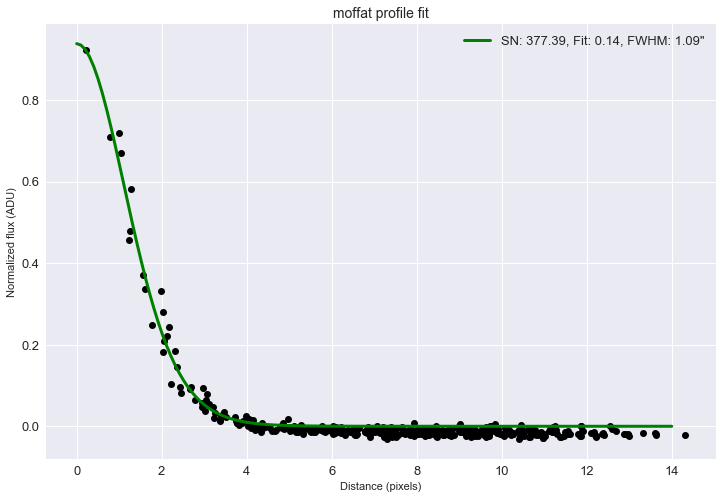

In [76]:
# Check fitting
if fitter.fit_info['final_func_val'] < 5.0:
    color = 'green'
else:
    color = 'red'
    
# Plot the data with the best-fit model
plt.figure()
plt.plot(pixel_distance, flux_counts, 'ko')
rx = np.linspace(0, int(max(pixel_distance)), int(max(pixel_distance)) * 10)
plt.plot(rx,
         fitted_model(rx),
         color=color,
         lw=3.0,
         label='SN: %.2f, Fit: %.2f, FWHM: %.2f"' % (isource['flux'] * sigma_detection,
                                                       fitter.fit_info['final_func_val'],
                                                       iFWHM))
plt.xlabel('Distance (pixels)')
plt.ylabel('Normalized flux (ADU)')
plt.title('%s profile fit' % model)
plt.legend()
plt.show()

### Background modelling

As we have seen in the case with non-uniform background, the constant median can be insuficient. Here we produce a 2D model of the background that can be subtracted from the original image to improve the modelling of the stars close to a very large extended source (or when the backrgound is not flat for any other reason)

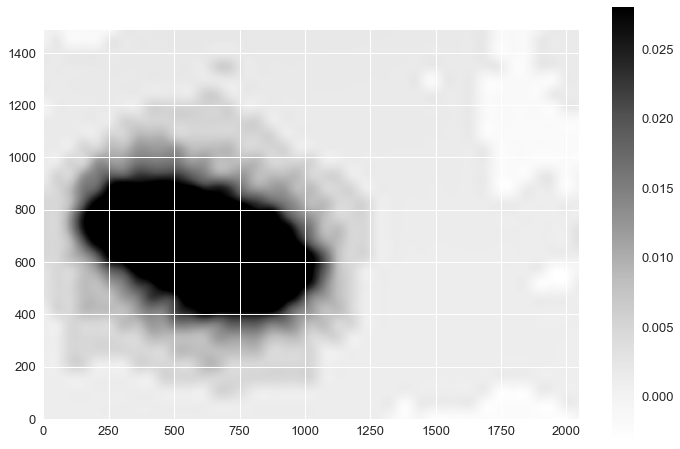

In [70]:
from photutils import Background2D, SigmaClip, MedianBackground
sigma_clip = SigmaClip(sigma=3., iters=10)
bkg_estimator = MedianBackground()
bkg = Background2D(data=sdss_g_hdu_list[0].data, 
                   box_size=(50, 50), 
                   filter_size=(3, 3),
                   sigma_clip=sigma_clip, 
                   bkg_estimator=bkg_estimator)
my_python_ds9(bkg.background)

Now let's go back to where the background was subtracted to verify the difference.

## Aperture photometry

We will work with the simple circular apertures. First we need to set the size we want and create the aperture objects:

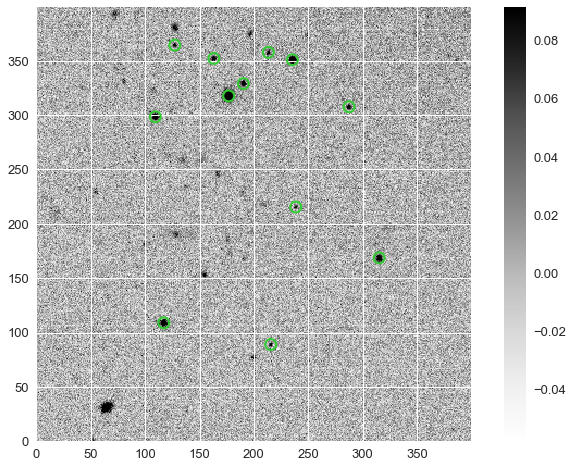

In [18]:
from photutils import CircularAperture

aperture_radius = 5.0

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=aperture_radius)

my_python_ds9(sdss_g_hdu_list[0].data[0:400, 0:400])
apertures.plot(color='limegreen', lw=2)

### Global Background subtraction

As we only want the flux from the sources we are interested in, we need to remove the contribution from the background. The simplest way is to remove the median value constant of the sigma clipped image that we calculated before to the entire array:

In [19]:
from photutils import aperture_photometry

bkg_subtracted_image = sdss_g_hdu_list[0].data - median
phot_table_global_bkg = aperture_photometry(bkg_subtracted_image, apertures)
print (phot_table_global_bkg)

 id      xcenter            ycenter        aperture_sum 
           pix                pix                       
--- ------------------ ------------------ --------------
  1  1486.638864525346  6.300533976629028  3.96116319449
  2  1361.937876867555  36.55248087345152  2.29569645431
  3 1976.4566047830601  49.50616579436974  3.22544990184
  4 1322.5223504784926  53.03722289735053  3.34147077215
  5  676.8606245948037  61.29755208861998  28.5747484527
  6  1795.991382458698  70.32024356716214 0.525493169539
  7 1362.1860810499215  83.62137856134737  3.03841979689
  8  215.4033023515488  89.00727305824422 0.899006516776
  9 1297.7504374295183 106.58694191268008  23.8306714569
 10  117.1127493520293  108.9173040879896  5.07778192953
...                ...                ...            ...
284 1409.4154398615296 1441.1432534967569  1.47522709955
285  1294.774715838578 1445.6531450032255  55.8997193252
286  275.9778023904703 1447.3846093019795  2.39332312586
287 389.82163167613135 1448.815

### Local Background subtraction

We could also remove the 2D background model that we calculated before, but it is usually more precise to create an annulus around the source we are interested in, and estimate the background level there.

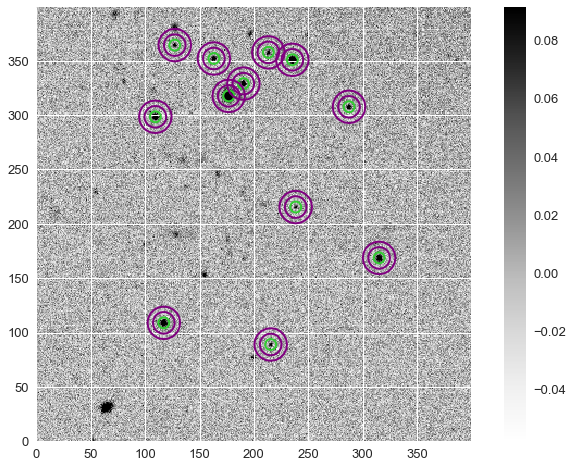

In [45]:
from photutils import CircularAnnulus

r_in = 10
r_out = 15

annulus_apertures = CircularAnnulus(positions, r_in=r_in, r_out=r_out)

my_python_ds9(sdss_g_hdu_list[0].data[0:400, 0:400])
apertures.plot(color='limegreen', lw=2)
annulus_apertures.plot(color='purple', lw=2, alpha=1)

The circular apertures and the annulus can be joined for a common photometry processing.

In [46]:
apers = [apertures, annulus_apertures]
phot_table_local_bkg = aperture_photometry(sdss_g_hdu_list[0].data, apers)
print(phot_table_local_bkg)    

 id      xcenter            ycenter       aperture_sum_0  aperture_sum_1
           pix                pix                                       
--- ------------------ ------------------ -------------- ---------------
  1  1486.638864525346  6.300533976629028  4.33447180029  0.620522946519
  2  1361.937876867555  36.55248087345152  2.66900506011 -0.138694719736
  3 1976.4566047830601  49.50616579436974  3.59875850764  0.352375615143
  4 1322.5223504784926  53.03722289735053  3.71477937795 -0.989652113345
  5  676.8606245948037  61.29755208861998  28.9480570585   0.76402552603
  6  1795.991382458698  70.32024356716214 0.898801775341  -1.10134681987
  7 1362.1860810499215  83.62137856134737  3.41172840269 -0.476559506534
  8  215.4033023515488  89.00727305824422  1.27231512258  0.138025177646
  9 1297.7504374295183 106.58694191268008  24.2039800627  0.155816756399
 10  117.1127493520293  108.9173040879896  5.45109053533 -0.431496239495
...                ...                ...          

Now we use the aperture_sum_1 to estimate the level of background around the source. We need to know the area of the annulus for this estimation:

In [47]:
bkg_mean = phot_table_local_bkg['aperture_sum_1'] / annulus_apertures.area()

And finally we can remove the background estimation to all pixels in the aperture:

In [48]:
bkg_sum = bkg_mean * apertures.area()
final_sum = phot_table_local_bkg['aperture_sum_0'] - bkg_sum
phot_table_local_bkg['residual_aperture_sum'] = final_sum
print(phot_table_local_bkg['residual_aperture_sum'])    

residual_aperture_sum
---------------------
        4.21036721099
        2.69674400406
        3.52828338461
        3.91270980062
        28.7952519533
        1.11907113931
          3.507040304
        1.24471008705
        24.1728167114
        5.53738978323
                  ...
        3.04226495063
        1.74608753458
        55.9327525152
        2.74848351096
        1.97581013336
         53.929489647
        16.0839914831
        3.97709054061
        3.17677906941
        2.34982300668
        2.80586526577
Length = 293 rows


In this comparison we see that many sources have the same flux with both methods but a significant amount of sources (the ones in the galaxy halo) have significantly more flux in the global subtraction method, as the flux from M102 is added to the one of the stars.

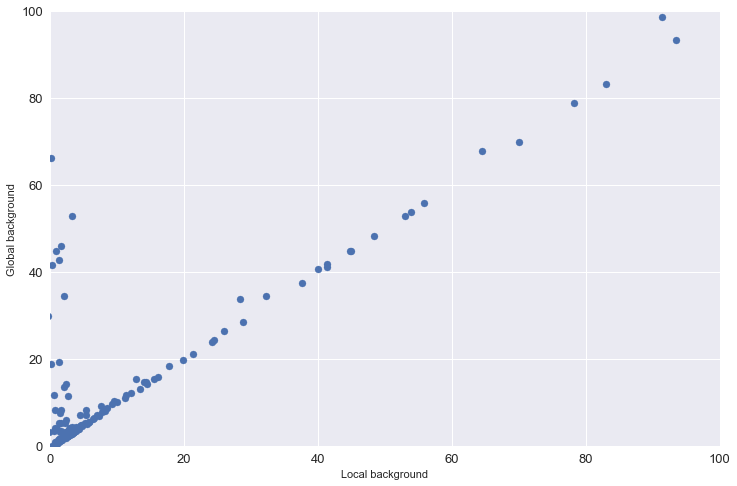

In [49]:
plt.scatter(phot_table_local_bkg['residual_aperture_sum'], phot_table_global_bkg['aperture_sum'])
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('Local background')
plt.ylabel('Global background')

Let's make a plot to verify this! Astropy qtables work similarly to Pandas, so we can make iloc searches.

### <span style="color:blue">Exercise PhotUtils:</span> Identify problematic sources
Locate which sources differ their flux in more than 50% between the measurement with local and global background estimation. Plot the results on the image.

TIP: Using the "pandas-like" tools can facilitate the selection

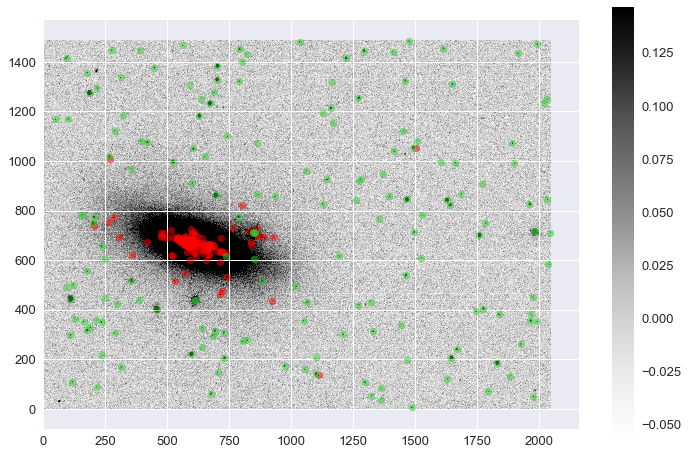

In [67]:
# %load -r 43-52 solutions/10_Astronomy.py
#phot_table_local_bkg.add_index('id')
very_different = phot_table_local_bkg[phot_table_local_bkg['residual_aperture_sum'] * 1.5
                                           < phot_table_global_bkg['aperture_sum']]

quite_similar = phot_table_local_bkg[phot_table_local_bkg['residual_aperture_sum'] * 1.5
                                           > phot_table_global_bkg['aperture_sum']]

my_python_ds9(sdss_g_hdu_list[0].data)
plt.scatter(very_different['xcenter'], very_different['ycenter'], c='red', alpha=0.5)
plt.scatter(quite_similar['xcenter'], quite_similar['ycenter'], c='limegreen', alpha=0.5)

#### Accessing to annulus pixels

By default when calling aperture_photometry, we only receive the sum of pixels and therefore we can only access to the mean of the pixel values inside an aperture. To properly measure the local background, we would need to get the median of the pixels in the annulus and preferably, perform a sigma clipping over the values.

Recently photutils enabled masks so we can actually do that!

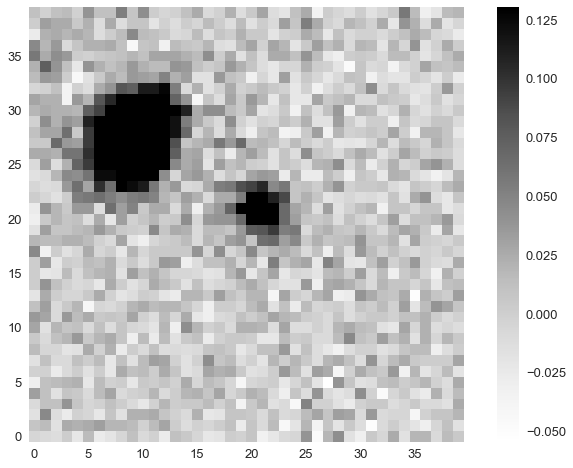

In [51]:
# Flat annulus - 11
# Source in annulus - 12

source_num = 12

x = phot_table_local_bkg[source_num]['xcenter'].value
y = phot_table_local_bkg[source_num]['ycenter'].value

stamp_radius = 20
my_python_ds9(sdss_g_hdu_list[0].data[int(y - stamp_radius):
                                      int(y + stamp_radius), 
                                      int(x - stamp_radius): 
                                      int(x + stamp_radius)])
plt.grid('off')

We can access to the annulus mask:

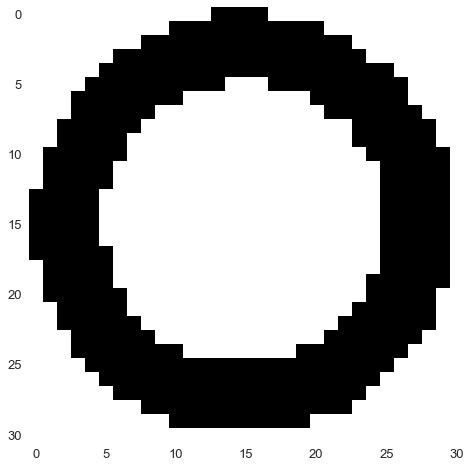

In [52]:
# Create annulus mask
annulus_apertures = CircularAnnulus((x, y), r_in=r_in, r_out=r_out)
masks = annulus_apertures.to_mask(method='center')
m0 = masks[0]

plt.imshow(m0)
plt.grid('off')

And apply it to the data:

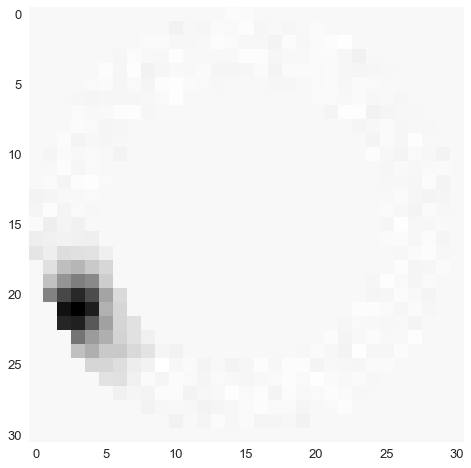

In [53]:
# Cut to data
cutout_data = m0.apply(sdss_g_hdu_list[0].data)

plt.imshow(cutout_data)
plt.grid('off')

Now that we have access to the pixels, we can perform the median and compare to the mean

In [54]:
annulus_array = cutout_data[cutout_data != 0]

# Apply statistics to masked data
mean = np.mean(annulus_array)
median = np.median(annulus_array)
std = np.std(annulus_array)
print (mean, median, std)

0.0401534742981 0.00813293457031 0.115648635068


And even sigma-clip the sources that may appear on top of the background. This creates a numpy.masked array:

In [55]:
from astropy.stats import sigma_clip

clip_annulus_array = sigma_clip(annulus_array, sigma=3, iters=2)

mean_clipped = np.ma.mean(clip_annulus_array)
median_clipped = np.ma.median(clip_annulus_array)
std_clipped = np.ma.std(clip_annulus_array)
print (mean_clipped, median_clipped, std_clipped)

0.0123201866672 0.00466918945312 0.0358663581849


### <span style="color:blue">Exercise PhotUtils 2:</span> Estimate aperture error
Compute what would be the measurement error for the last aperture (the one with sigma clipping)

$$
\sigma^2_{F} = \sum_i{\sigma^2_{i}+F/g}
$$

TIP: Gain is the exposure time when pixels are in e/s

In [78]:
# %load -r 56-61 solutions/10_Astronomy.py
g = float(sdss_g_hdu_list[0].header['EXPTIME'])
aperture_area = apertures.area()  # or also = math.pi * aperture_radius**2
F = phot_table_local_bkg['aperture_sum_1'][source_num] - (median_clipped * aperture_area)
sigma_F = np.sqrt((F / g) + (aperture_area * std_clipped ** 2))

print (phot_table_local_bkg['aperture_sum_1'][source_num],  sigma_F)

15.8430648047 0.622996241149


In this link you can find details on how to estimate the error:
http://photutils.readthedocs.io/en/stable/photutils/aperture.html#error-estimation

# Matching catalogues

**astropy.coordinates** contains commonly-used tools for comparing or matching coordinate objects. It supports leverages the coordinate framework to make it straightforward to find the closest coordinates in a catalog to a desired set of other coordinates. 

Let's do a new catalogue with the SDSS r band image on the same location in the sky

In [57]:
sdss_r_hdu_list = fits.open('../resources/sdss_r.fits')
sdss_r_hdu_list.info()

Filename: ../resources/sdss_r.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      96   (2048, 1489)   float32   
  1              ImageHDU         6   (2048,)   float32   
  2              BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3              BinTableHDU     79   1R x 31C   [J, 3A, J, A, D, D, 2J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E]   


If we plot the previous apertures in the sky, we realize that there is a slight offset (either due to pointing inaccuracy or dithering observarions)

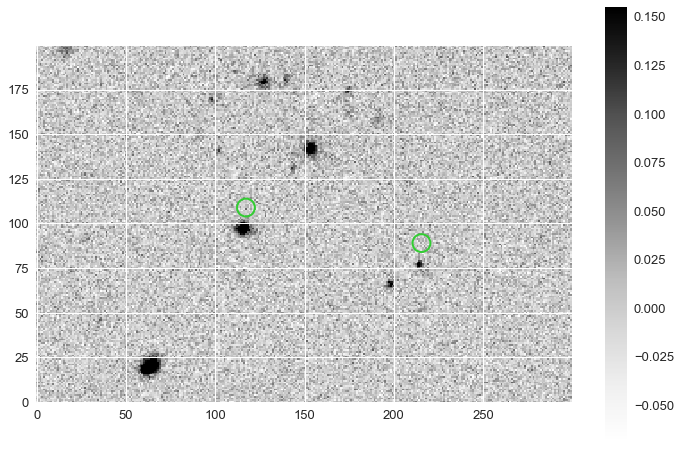

In [58]:
my_python_ds9(sdss_r_hdu_list[0].data[0:200, 0:300])
apertures.plot(color='limegreen', lw=2)

In order to make a r band catalogue, we follow the same process as before 

[   don't replicate code like we do here... you should create a function or Scott will get mad!!   ]

In [59]:
print ("Image statistics...")
mean_r, median_r, std_r = sigma_clipped_stats(sdss_r_hdu_list[0].data, sigma=3.0, iters=5)    

print ("Source detection...")
sources_r = daofind(sdss_r_hdu_list[0].data - median_r)    

print ("Aperture definition...")
positions_r = (sources_r['xcentroid'], sources_r['ycentroid'])
apertures_r = CircularAperture(positions_r, r=aperture_radius)
annulus_apertures_r = CircularAnnulus(positions_r, r_in=10, r_out=15)

print ("Photometry calculation...")
apers_r = [apertures_r, annulus_apertures_r]
phot_table_local_bkg_r = aperture_photometry(sdss_r_hdu_list[0].data, apers_r)
bkg_mean_r = phot_table_local_bkg_r['aperture_sum_1'] / annulus_apertures_r.area()
bkg_sum_r = bkg_mean_r * apertures_r.area()
final_sum_r = phot_table_local_bkg_r['aperture_sum_0'] - bkg_sum_r
phot_table_local_bkg_r['residual_aperture_sum'] = final_sum_r

print ("..ready!")

Image statistics...
Source detection...
Aperture definition...
Photometry calculation...
..ready!


In addition we se that more/different objects have been detected due to the different spectral emission of the sources

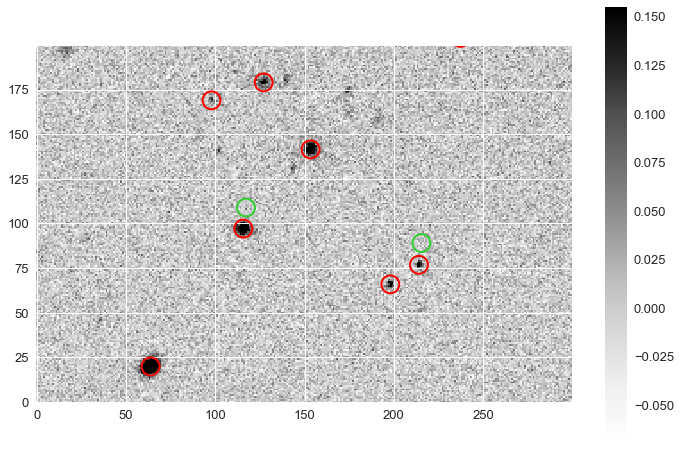

In [60]:
my_python_ds9(sdss_r_hdu_list[0].data[0:200, 0:300])
apertures.plot(color='limegreen', lw=2)
apertures_r.plot(color='red', lw=2)

First we create the two catalogues in sky coordinates using the WCS information as matching needs to be happen the same frame

In [61]:
origin = 0
### g band catalogue ###
# Create wcs object
sdss_g_image_wcs = wcs.WCS(sdss_g_hdu_list[0].header)

# Pixels to Sky
lon_g, lat_g = sdss_g_image_wcs.all_pix2world(phot_table_local_bkg['xcenter'], 
                                              phot_table_local_bkg['ycenter'], 
                                              origin)
cat_g = SkyCoord(ra=lon_g*u.degree, dec=lat_g*u.degree)  


### r band catalogue ###
# Create wcs object
sdss_r_image_wcs = wcs.WCS(sdss_r_hdu_list[0].header)

# Pixels to Sky
lon_r, lat_r = sdss_r_image_wcs.all_pix2world(phot_table_local_bkg_r['xcenter'], 
                                          phot_table_local_bkg_r['ycenter'], 
                                          origin)
cat_r = SkyCoord(ra=lon_r*u.degree, dec=lat_r*u.degree)  

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


### Closest catalogue matching
The following function performs the matching between the two catalogues, and returns what is the closest "r" source to each of the "g" sources. Therefore the resulting arrays contain the same number of indices than the catalogue "g".

293


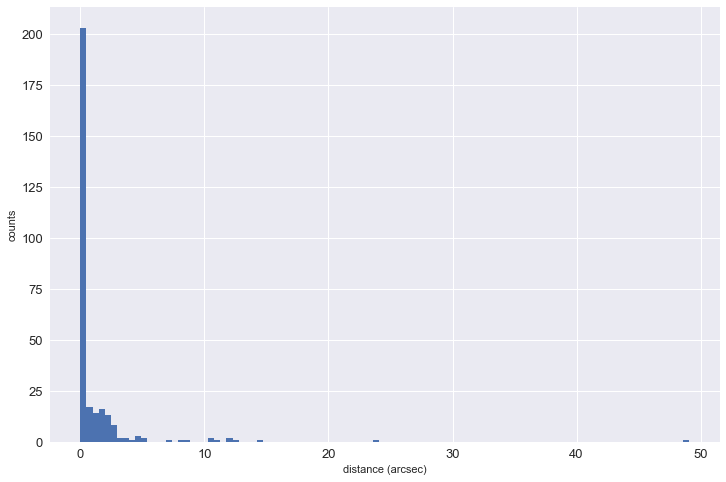

In [79]:
id_r, d2d, d3d = cat_g.match_to_catalog_sky(cat_r)

print (len(id_r))

hist_data = plt.hist(d2d.to('arcsec'), bins=100)
plt.xlabel('distance (arcsec)')
plt.ylabel('counts')

Comparing the fluxes, some matches show a very large difference, due to source mismatch and not due to color.

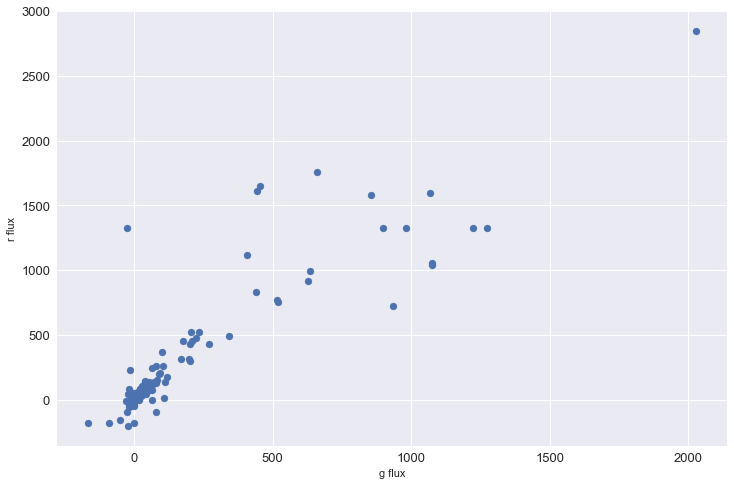

In [80]:
plt.scatter(phot_table_local_bkg['residual_aperture_sum'], phot_table_local_bkg_r[id_r]['residual_aperture_sum'])
plt.xlabel('g flux')
plt.ylabel('r flux')

### Search around coordinates matching
The following function performs the matching between the two catalogues, returning only those sources that match within certain tolerance in the sky. Therefore

225


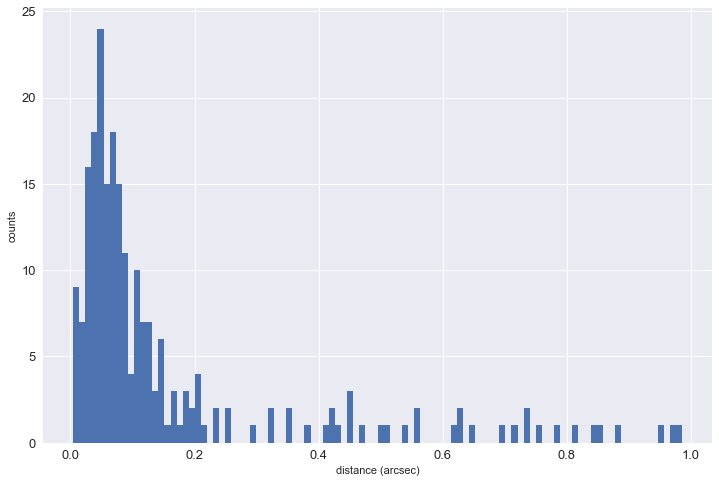

In [81]:
id_r_around, id_g_around, d2d_around, d3d_around = cat_g.search_around_sky(cat_r, 1*u.arcsec)  

print (len(id_r_around))

hist_data = plt.hist(d2d_around.to('arcsec'), bins=100)
plt.xlabel('distance (arcsec)')
plt.ylabel('counts')

Now we can see how the biggest outliers have disappeared, remaining only the difference in flux due to color.

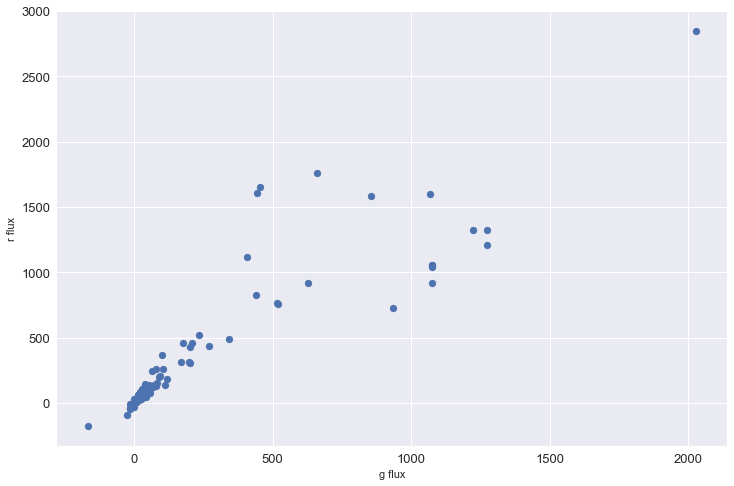

In [82]:
plt.scatter(phot_table_local_bkg[id_g_around]['residual_aperture_sum'], phot_table_local_bkg_r[id_r_around]['residual_aperture_sum'])
plt.xlabel('g flux')
plt.ylabel('r flux')

### From fluxes to magnitudes (in SDSS)
The images we use are already calibrated in photometry, and the units used are nanomaggies. Therefore

m = [22.5 mag] – 2.5 log10 f.

http://www.sdss.org/dr12/algorithms/magnitudes/#nmgy 

In [88]:
def to_sdss_mag(fluxes):
    return 22.5 - 2.5*np.log10(fluxes)

#### Checking relation between measured flux and calibrated magnitude

/Users/francesc/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


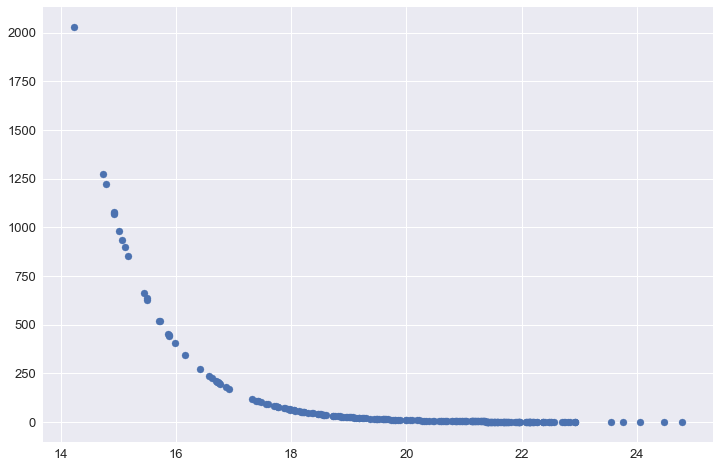

In [89]:
mags_g = to_sdss_mag(phot_table_local_bkg['residual_aperture_sum'])
plt.scatter(mags_g, phot_table_local_bkg['residual_aperture_sum'])

### Matching to an external catalogue

Load the SDSS catalogue with astroquery that overlaps the image

In [90]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords

region = np.mean(sdss_r_image_wcs.calc_footprint(), axis=0)
c = SkyCoord(region[0] * u.degree, region[1] * u.degree, frame='icrs')

sdss_query = SDSS.query_region(c,
                               spectro=False,
                               radius=20*u.arcmin,
                               photoobj_fields=['ra','dec','u','g','r','i','z'])
print(sdss_query)

      ra           dec         u        g        r        i        z    
------------- ------------- -------- -------- -------- -------- --------
226.256423737 56.1264971196  22.4092 22.54401 21.89829 21.64783 20.84672
 226.25738166 55.8659839448 23.47725 23.47035 23.02746 22.43706 22.22186
226.259104426 55.7483355594   24.866  23.6284 22.70043 23.09313 22.56116
 226.26081025 55.9748124271 24.72773  24.5149 25.48138 24.06281 20.55524
226.261183203 56.0041628538 23.95651 20.94683 19.48995 18.41593 17.79916
226.261496452 56.1269315215  -9999.0  -9999.0  -9999.0  -9999.0  -9999.0
226.262741165 55.8202049579 22.94524 20.61507 19.22542 17.83784 17.10099
226.263271933 55.8716263752  -9999.0  -9999.0  -9999.0  -9999.0  -9999.0
226.264902686 55.6527164198 24.77525 23.05575 21.09869 20.44911 20.15141
226.268423554 55.6203137095 23.60186 22.32089 21.23982 20.56234 20.93793
          ...           ...      ...      ...      ...      ...      ...
226.908317725 55.9778617617 22.21526  20.6649 20.11

#### Checking the catalogue: Color - Color plot


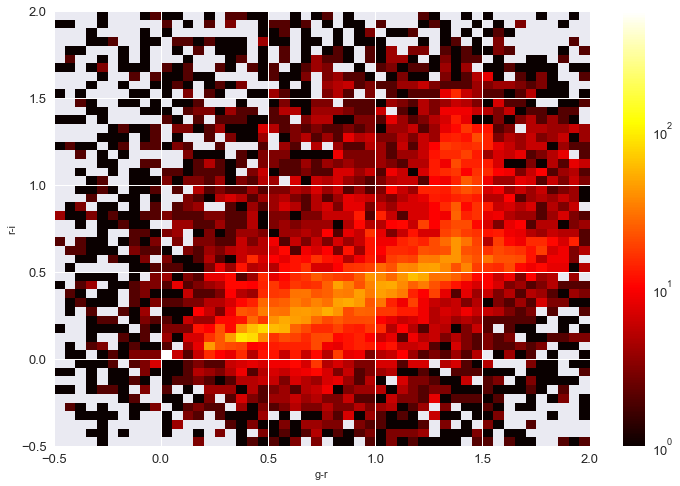

In [91]:
from matplotlib.colors import LogNorm

plt.hist2d(sdss_query['g'] - sdss_query['r'], 
           sdss_query['r'] - sdss_query['i'],
           range=[(-0.5,2), (-0.5,2)], 
           bins=50, 
           norm=LogNorm(),
          cmap='hot')
plt.colorbar()
plt.xlabel('g-r')
plt.ylabel('r-i')

Finally we can check that calibrated photometry matches within some margin (probably due to different extraction method - Aperture vs Model)

595


/Users/francesc/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


(15, 25)

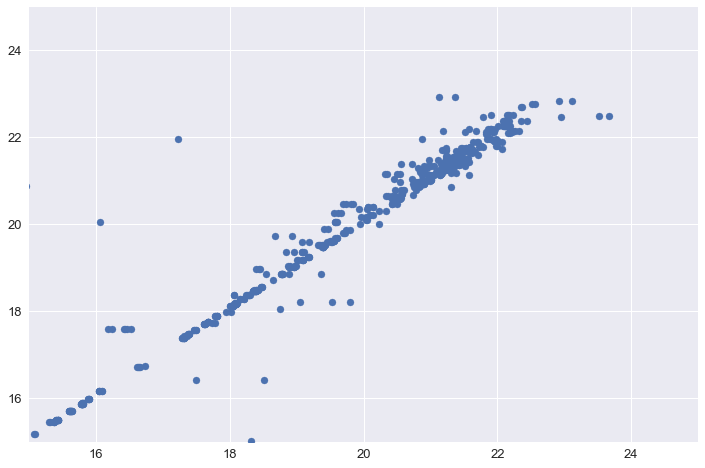

In [92]:
cat_sdss_query = SkyCoord(ra=sdss_query['ra'] * u.degree, dec=sdss_query['dec'] * u.degree)  

id_query_around, id_g_around, d2d_around, d3d_around = cat_g.search_around_sky(cat_sdss_query, 0.5*u.arcsec)  

print (len(id_query_around))

plt.scatter(sdss_query[id_query_around]['g'], to_sdss_mag(phot_table_local_bkg[id_g_around]['residual_aperture_sum']))
plt.xlim(15, 25)
plt.ylim(15,25)